In [1]:
from transformers import AutoTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import torch
import os
import pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


In [2]:
import pandas as pd
def load_data():
    prefix="/content/drive/MyDrive/94812/hw1/"
    all_docs = []
    topic_list = ['business','entertainment','politics','sport','tech']
    for topic in topic_list:
        docs=os.listdir(prefix+topic)
        for doc in docs:
            path = prefix+topic+'/'+doc
            file = open(path, "r")
            content = file.read()
            row = [topic, content]
            all_docs.append(row)
    df = pd.DataFrame(all_docs, columns = ['topic','content'])
    return df
df = load_data()
df

,topic,content
0,business,Golden rule 'intact' says ex-aide\n\nChancello...
1,business,Beer giant swallows Russian firm\n\nBrewing gi...
2,business,Deutsche Boerse set to 'woo' LSE\n\nBosses of ...
3,business,GM in crunch talks on Fiat future\n\nFiat will...
4,business,Sluggish economy hits German jobs\n\nThe numbe...
...,...,...
2220,tech,Slim PlayStation triples sales\n\nSony PlaySta...
2221,tech,Loyalty cards idea for TV addicts\n\nViewers c...
2222,tech,Software watching while you work\n\nSoftware t...
2223,tech,Sony PSP tipped as a 'must-have'\n\nSony's Pla...


In [3]:
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [27]:
def sentiment_analysis(text):
    inputs = tokenizer(text, padding=False, truncation=True, max_length=512, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=1)

    sentiment_map = {0: "Negative", 1: "Positive"}
    sentiment_score, sentiment_index = torch.max(predictions, dim=1)
    sentiment_label = sentiment_map[int(sentiment_index)]

    return sentiment_label, sentiment_score.item()


In [28]:
sentiment_analysis('dislike')

('Negative', 0.9998353719711304)

In [29]:
from tqdm.auto import tqdm
model.to(device)
results= []
for i in tqdm(range(len(df)), "inferencing..."):
    text = df.iloc[i]['content']
    label, score = sentiment_analysis(text)
    results.append([label, score])
df[['sentiment', 'score']] = results
df

inferencing...:   0%|          | 0/2225 [00:00<?, ?it/s]

,topic,content,sentiment,sentiment_label,score
0,business,Golden rule 'intact' says ex-aide\n\nChancello...,Negative,True,0.99692
1,business,Beer giant swallows Russian firm\n\nBrewing gi...,Positive,False,0.687573
2,business,Deutsche Boerse set to 'woo' LSE\n\nBosses of ...,Negative,True,0.999741
3,business,GM in crunch talks on Fiat future\n\nFiat will...,Negative,True,0.99882
4,business,Sluggish economy hits German jobs\n\nThe numbe...,Negative,True,0.999845
...,...,...,...,...,...
2220,tech,Slim PlayStation triples sales\n\nSony PlaySta...,Positive,False,0.696142
2221,tech,Loyalty cards idea for TV addicts\n\nViewers c...,Positive,True,0.943511
2222,tech,Software watching while you work\n\nSoftware t...,Positive,True,0.950391
2223,tech,Sony PSP tipped as a 'must-have'\n\nSony's Pla...,Positive,True,0.999751


<Axes: xlabel='sentiment', ylabel='count'>

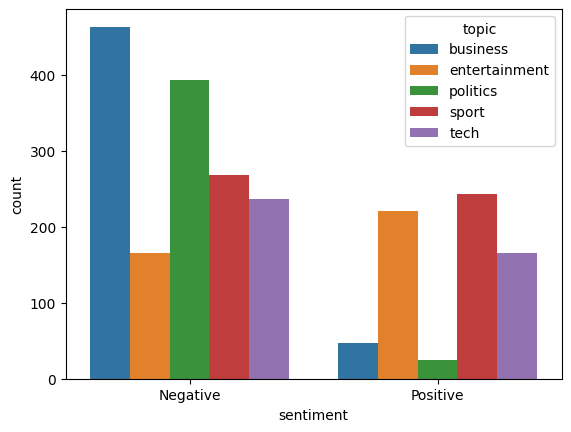

In [30]:
import seaborn as sns
sns.countplot(df, x='sentiment', hue='topic', )

The dataset contains more negative articles than positive. \
Business, Politics are mostly negative sentiment. \
Sports, and tech have also have more negative classes but are more balanced. \
Entertainment has more positive class than negative.\
We'll try to adjust threshold of probability of positive class to better analyze and also include a neutral class.

In [55]:
def sentiment_analysis_3class(text):
    inputs = tokenizer(text, padding=False, truncation=True, max_length=512, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = softmax(outputs.logits, dim=1)
        # print(predictions)
    score = predictions[0,1].item()
    # print(score) #Positive classes' probability

    if score>0.75:
      sentiment_label='Positive'
    elif score<0.25:
      sentiment_label='Negative'
    else:
      sentiment_label='Neutral'

    return sentiment_label, score


In [59]:
sentiment_analysis_3class("This is a neutral sentence")

('Neutral', 0.634053647518158)

In [60]:
results= []
for i in tqdm(range(len(df)), "inferencing..."):
    text = df.iloc[i]['content']
    label, score = sentiment_analysis_3class(text)
    results.append([label, score])
df[['sentiment', 'score']] = results
df

inferencing...:   0%|          | 0/2225 [00:00<?, ?it/s]

,topic,content,sentiment,score
0,business,Golden rule 'intact' says ex-aide\n\nChancello...,Negative,0.00308
1,business,Beer giant swallows Russian firm\n\nBrewing gi...,Neutral,0.687573
2,business,Deutsche Boerse set to 'woo' LSE\n\nBosses of ...,Negative,0.000259
3,business,GM in crunch talks on Fiat future\n\nFiat will...,Negative,0.00118
4,business,Sluggish economy hits German jobs\n\nThe numbe...,Negative,0.000155
...,...,...,...,...
2220,tech,Slim PlayStation triples sales\n\nSony PlaySta...,Neutral,0.696142
2221,tech,Loyalty cards idea for TV addicts\n\nViewers c...,Positive,0.943511
2222,tech,Software watching while you work\n\nSoftware t...,Positive,0.950391
2223,tech,Sony PSP tipped as a 'must-have'\n\nSony's Pla...,Positive,0.999751


<Axes: xlabel='sentiment', ylabel='count'>

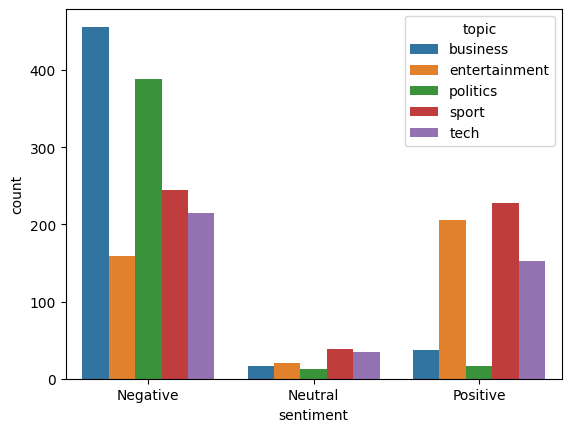

In [61]:
sns.countplot(df, x='sentiment', hue='topic', )

We can see with a threshold 0.25, 0.75(p>0.75 positive, p<0.25 negative, 0.25~0.75 neutral)
There are still very few neutral classes. We can say Bert model fined tuned on yelp polarity dataset is very confident and extreme about the sentiment prediction. \
Tech and Sport articles have more neutral classes than others.